In [1]:
seed = 32
import pandas as pd
import numpy as np

In [2]:
CLEANED_DATA = "cleaned_data.xlsx"
ts_features_targets = pd.read_excel(CLEANED_DATA)
ts_features_targets = ts_features_targets.set_index(ts_features_targets['DATE']).drop(['DATE'],axis = 1)

In [3]:
def preprocessing(original_data):
    clean_data = original_data.copy()
    clean_data.drop_duplicates(keep='first', inplace=True)
    ### fill missing data 
    clean_data.interpolate(inplace=True)
    clean_data.fillna(method='bfill',inplace=True)    
    print('missing values:',clean_data.isna().sum().sum())
    return clean_data

ts_features_targets = preprocessing(ts_features_targets)

missing values: 0


# I. This is used when we want to run the anomalies detection on the hole dataset

# scaling and transform data
def data_scaling_transform(X_train, X_test, y_train, y_test):
    ### transform input variables
    scaler = StandardScaler().fit(X_train)
    X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns, index=X_train.index)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)
    ## transform target variables
    transformer = PowerTransformer().fit(y_train)
    y_train = transformer.transform(y_train)
    y_test = transformer.transform(y_test)     
    return X_train, X_test, y_train, y_test

from sklearn.model_selection import train_test_split

X = ts_features_targets.drop('APP', axis=1)
y = ts_features_targets[['APP']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=seed, shuffle=True)
X_train, X_test, y_train, y_test = data_scaling_transform(X_train, X_test, y_train, y_test)
# split data into train & test sets
X_train = tf.cast(X_train.values, dtype=tf.float32)
X_test = tf.cast(X_test.values, dtype=tf.float32)
y_train = tf.cast(y_train, dtype=tf.float32)
y_test = tf.cast(y_test, dtype=tf.float32)

from keras import Model
from keras.layers import Input, Dense
from keras.optimizers import RMSprop
input_dim = len(X.columns)
latent_dim = 2
input_layer=Input(shape=(input_dim,)) #Define the input layer

encoded= Dense(units=input_dim,activation="tanh")(input_layer) 
encoded= Dense(units=3,activation="tanh")(encoded) 

laten_vector= Dense(units=latent_dim,activation="tanh")(encoded)

decoded= Dense(units=3,activation="tanh")(laten_vector)
decoded= Dense(units=input_dim,activation="tanh")(decoded)

output_layer= Dense(units=input_dim,activation="linear",name='decoded')(decoded)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=RMSprop(),loss="mean_squared_error",metrics=["mae"])
model.summary()
#plot_model(model,to_file='ae.png',show_shapes=True)

import tensorflow as tf
from tensorflow.keras.layers import Dense, InputLayer
from alibi_detect.od import OutlierAEGMM
n_features = len(X.columns)
latent_dim = 2
n_gmm = 1
encoder_net = tf.keras.Sequential(
[
    InputLayer(input_shape=(n_features,)),
    Dense(3, activation=tf.nn.tanh),
    Dense(latent_dim, activation=None)
])
decoder_net = tf.keras.Sequential(
[
    InputLayer(input_shape=(latent_dim,)),
    Dense(3, activation=tf.nn.tanh),
    Dense(n_features, activation=None)
])
gmm_density_net = tf.keras.Sequential(
[
    InputLayer(input_shape=(latent_dim + 2,)),
    Dense(3, activation=tf.nn.tanh),
    Dense(n_gmm, activation=tf.nn.softmax)
])
od = OutlierAEGMM(
    threshold=5,
    encoder_net=encoder_net,
    decoder_net=decoder_net,
    gmm_density_net=gmm_density_net,
    n_gmm=1)
od.fit(
    X_train,
    epochs=10,
    batch_size=1024
)
od.infer_threshold(
    X.values,
    threshold_perc=95
)



preds = od.predict(
    X.values,
    return_instance_score=True
)
preds['data']['instance_score']

# II. This is used when we want to run the anomalies detection on each month

In [4]:
saisons = ['Automne', 'Hiver', 'Printemps', 'Eté']

def create_seasonal_data(full_data):
    data = [pd.DataFrame() for i in range(4)]     
    month = pd.DatetimeIndex(full_data.index).month
    #Autumn
    data[0] = full_data[np.logical_or(month==9,np.logical_or(month==10,month==11))] 
    #Winter
    data[1] = full_data[np.logical_or(month==12,np.logical_or(month==1, month==2))]   
    #Spring
    data[2] = full_data[np.logical_or(month==3,np.logical_or(month==4, month==5))]
    #Summer
    data[3] = full_data[np.logical_or(month==6,np.logical_or(month==7, month==8))] 
    return data

seasonal_data = create_seasonal_data(ts_features_targets)

In [5]:
from sklearn.model_selection import train_test_split
# split data into train & test sets
def split_data(seasonal_data):
    data = []
    for ts_features_targets in seasonal_data:
        X = ts_features_targets.drop('APP', axis=1)
        y = ts_features_targets[['APP']]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=seed, shuffle=True)
        data.append([X_train, X_test, y_train, y_test, X, y])
    return data
data = split_data(seasonal_data)

In [6]:
import tensorflow as tf
from sklearn.preprocessing import PowerTransformer, StandardScaler
# scaling and transform data
def data_scaling_transform(seasonal_data):
    data = []
    for elem in seasonal_data:
        X_train, X_test, y_train, y_test, X, y = elem
        ### transform input variables
        scaler = StandardScaler().fit(X_train)
        X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns, index=X_train.index)
        X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)
        ## transform target variables
        transformer = PowerTransformer().fit(y_train)
        y_train = transformer.transform(y_train)
        y_test = transformer.transform(y_test) 

        X_train = tf.cast(X_train.values, dtype=tf.float32)
        X_test = tf.cast(X_test.values, dtype=tf.float32)
        y_train = tf.cast(y_train, dtype=tf.float32)
        y_test = tf.cast(y_test, dtype=tf.float32)
        data.append([X_train, X_test, y_train, y_test, X, y])
    return data
data = data_scaling_transform(data)

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, InputLayer
from alibi_detect.od import OutlierAEGMM
#from keras.layers import InputLayer, Dense
n_features = 4
latent_dim = 2
n_gmm = 1
def create_model(n_features, latent_dim, n_gmm):
    encoder_net = tf.keras.Sequential(
    [
        InputLayer(input_shape=(n_features,)),
        Dense(3, activation=tf.nn.tanh),
        Dense(latent_dim, activation=None)
    ])
    decoder_net = tf.keras.Sequential(
    [
        InputLayer(input_shape=(latent_dim,)),
        Dense(3, activation=tf.nn.tanh),
        Dense(n_features, activation=None)
    ])
    gmm_density_net = tf.keras.Sequential(
    [
        InputLayer(input_shape=(latent_dim + 2,)),
        Dense(3, activation=tf.nn.tanh),
        Dense(n_gmm, activation=tf.nn.softmax)
    ])
    od = OutlierAEGMM(
        threshold=5,
        encoder_net=encoder_net,
        decoder_net=decoder_net,
        gmm_density_net=gmm_density_net,
        n_gmm=1
    )
    return od
od = create_model(n_features, latent_dim, n_gmm)


import tensorflow as tf
from tensorflow.keras.layers import Dense, InputLayer
#from keras.layers import InputLayer, Dense

def create_model(n_features, latent_dim, n_gmm):
    encoder_net = tf.keras.Sequential(
    [
        InputLayer(input_shape=(n_features,)),
        Dense(3, activation=tf.nn.tanh),
        Dense(latent_dim, activation=None)
    ])
    decoder_net = tf.keras.Sequential(
    [
        InputLayer(input_shape=(latent_dim,)),
        Dense(3, activation=tf.nn.tanh),
        Dense(n_features, activation=None)
    ])
    gmm_density_net = tf.keras.Sequential(
    [
        InputLayer(input_shape=(latent_dim + 2,)),
        Dense(3, activation=tf.nn.tanh),
        Dense(n_gmm, activation=tf.nn.softmax)
    ])
    od = OutlierAEGMM(
        threshold=5,
        encoder_net=encoder_net,
        decoder_net=decoder_net,
        gmm_density_net=gmm_density_net,
        n_gmm=1
    )
    return od


from keras import Model
from keras.layers import Input, Dense
from keras.optimizers import RMSprop

def create_ae(input_dim, latent_dim):
    input_layer=Input(shape=(input_dim,)) #Define the input layer
    
    encoded= Dense(units=input_dim,activation="tanh")(input_layer) 
    encoded= Dense(units=3,activation="tanh")(encoded) 
    
    laten_vector= Dense(units=latent_dim,activation="tanh")(encoded)

    decoded= Dense(units=3,activation="tanh")(laten_vector)
    decoded= Dense(units=input_dim,activation="tanh")(decoded)
    
    output_layer= Dense(units=input_dim,activation="linear",name='decoded')(decoded)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=RMSprop(),loss="mean_squared_error",metrics=["mae"])
    model.summary()
    #plot_model(model,to_file='ae.png',show_shapes=True)
    return model


In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, InputLayer
from alibi_detect.od import OutlierAEGMM

result = []
for index, elem in enumerate(data):
    # split data into train & test sets
    X_train, X_test, y_train, y_test, X, y = elem
    print(saisons[index], str(len(X)))
    n_features = len(X.columns)
    latent_dim = 2
    n_gmm = 1
    
    od.fit(
        X_train,
        epochs=10,
        batch_size=1024
    )
    od.infer_threshold(
        X.values,
        threshold_perc=95
    )
    preds = od.predict(
        X.values,
        return_instance_score=True
    )
    result.append(preds)

Automne 661
1/1 [=] - 0s 23ms/step - loss: 1.9405

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Hiver 854
1/1 [=] - 0s 26ms/step - loss: 1.9298
Printemps 513
1/1 [=] - 0s 27ms/step - loss: 1.9626
Eté 144
1/1 [=] - 0s 22ms/step - loss: 1.9614


Automne


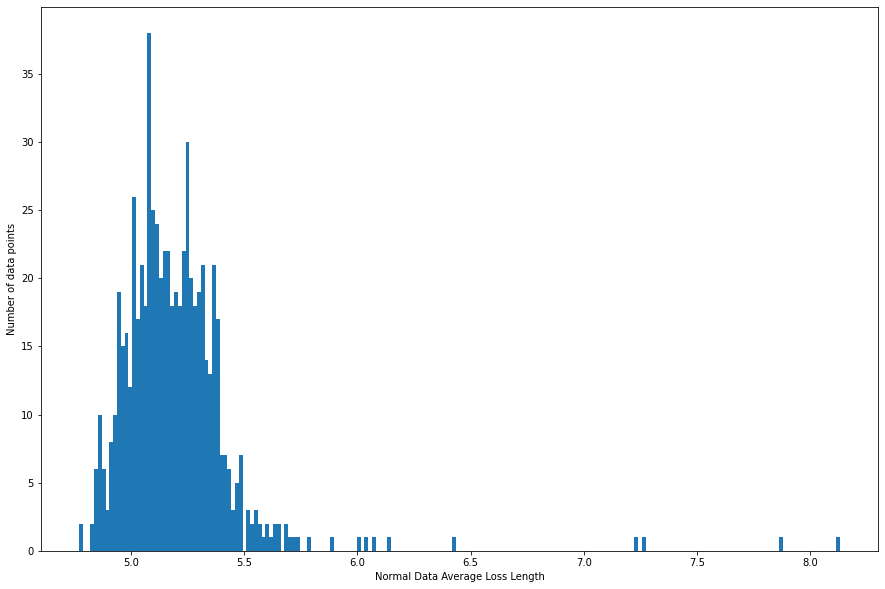

Hiver


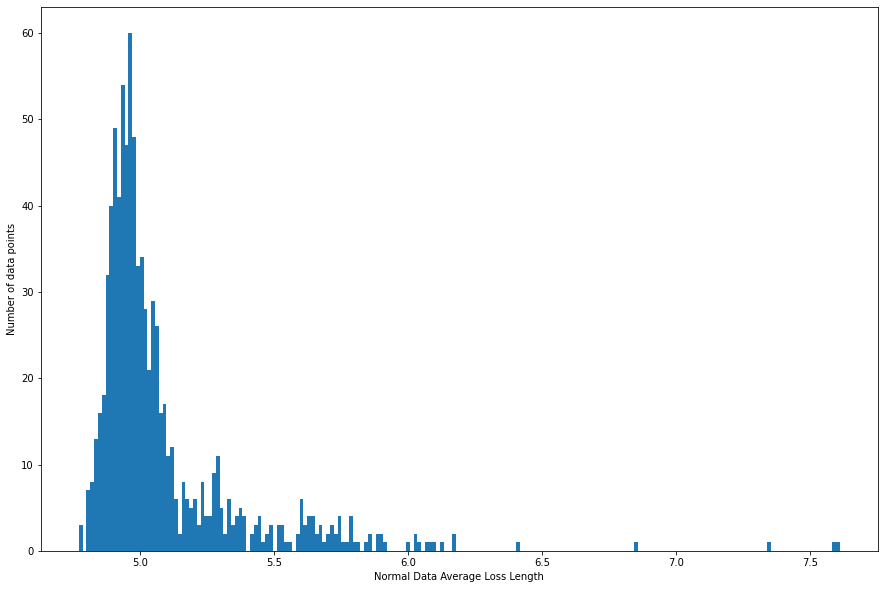

Printemps


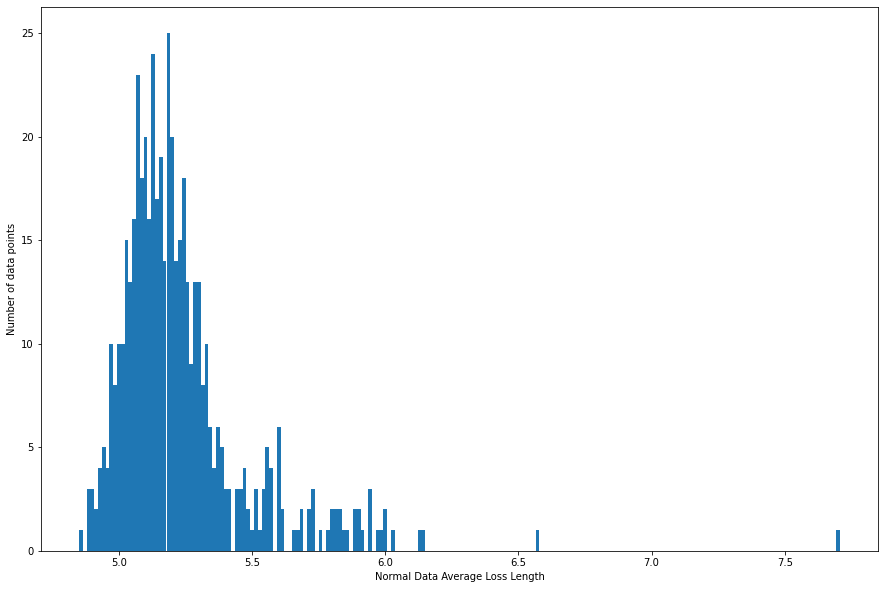

Eté


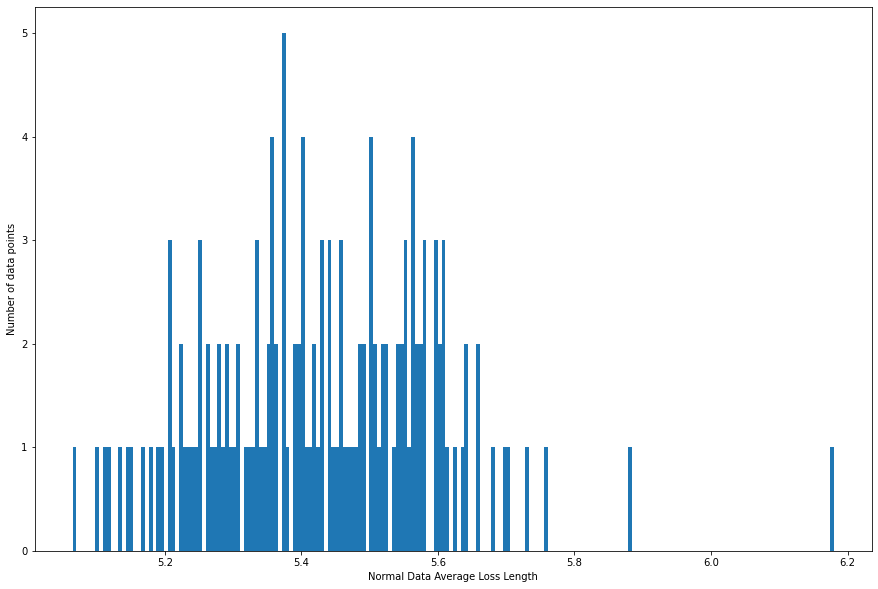

In [9]:
import matplotlib.pyplot as plt 

for index, elem in enumerate(result):
    print(saisons[index])
    plt.figure(figsize=(15,10))
    plt.hist(elem['data']['instance_score'],bins=200)
    plt.xlabel("Normal Data Average Loss Length")
    plt.ylabel("Number of data points")
    plt.show()
    #anoamlies_indexs = [index  for index, elem in enumerate(elem['data']['instance_score']) if elem >=9]
    #cleaned_data = X.drop(X.index[anoamlies_indexs])
    #cleaned_data = cleaned_data.merge(y, left_index=True, right_index=True)
#cleaned_data.to_csv('cleaned_data_with_AEGMM.csv')#, index=False)

# III. Eliminate anomalies for the hole dataset

In [ ]:
data_index = 3
threshhold = 7

In [ ]:
anoamlies_indexs = [index  for index, elem in enumerate(result[data_index]['data']['instance_score']) if elem >=threshhold]

In [ ]:
cleaned_data = data[data_index][4].drop(data[data_index][4].index[anoamlies_indexs])

In [ ]:
cleaned_data = cleaned_data.merge(data[data_index][5], left_index=True, right_index=True)

In [ ]:
cleaned_data.to_csv('cleaned_data_with_AEGMM.csv')#, index=False)

In [ ]:
## Test data for the four seasons

In [ ]:
final_data= pd.DataFrame()
data_index = [0,1,2,3]
threshhold = [4,4,3.3,3.2]
for idx, season in enumerate(data_index):
    print(saisons[idx], str(len(data[idx][4])))
    anoamlies_indexs = [index  for index, elem in enumerate(result[season]['data']['instance_score']) if elem >=threshhold[idx]]
    cleaned_data = data[idx][4].drop(data[idx][4].index[anoamlies_indexs])
    cleaned_data = cleaned_data.merge(data[idx][5], left_index=True, right_index=True)
    final_data = final_data.append(cleaned_data)
final_data.to_csv('cleaned_data_with_AEGMM.csv')#, index=False)

# Big test

In [12]:
from Prediction import *

In [ ]:
threshhold = []
threshhold.append(np.arange(3, 35, 0.1).tolist())
threshhold.append(np.arange(3.7, 8, 0.1).tolist())
threshhold.append(np.arange(3, 10, 0.1).tolist())
threshhold.append(np.arange(2.7, 10, 0.1).tolist())

In [19]:
threshhold = []
threshhold.append(np.arange(5.5, 7.5, 0.2).tolist())
threshhold.append(np.arange(5.4, 6.6, 0.2).tolist())
threshhold.append(np.arange(5.4, 6.6, 0.2).tolist())
threshhold.append(np.arange(5.2, 6, 0.2).tolist())

In [22]:
count = 0
final_result = []
seasons = [0,1,2,3]
for automne_threshhold in threshhold[0]:
    for hiver_threshhold in threshhold[1]:
        for printemps_threshhold in threshhold[2]:
            for ete_threshhold in threshhold[3]:
                
                local_df= pd.DataFrame()
                anoamlies_indexs_automne = [index  for index, elem in enumerate(result[0]['data']['instance_score']) if elem >=automne_threshhold]
                anoamlies_indexs_hiver = [index  for index, elem in enumerate(result[1]['data']['instance_score']) if elem >=hiver_threshhold]
                anoamlies_indexs_printemps = [index  for index, elem in enumerate(result[2]['data']['instance_score']) if elem >=printemps_threshhold]
                anoamlies_indexs_ete = [index  for index, elem in enumerate(result[3]['data']['instance_score']) if elem >=ete_threshhold]
                    
                cleaned_data = data[0][4].drop(data[0][4].index[anoamlies_indexs_automne])
                cleaned_data = cleaned_data.merge(data[0][5], left_index=True, right_index=True)
                local_df = local_df.append(cleaned_data)
                
                cleaned_data = data[1][4].drop(data[1][4].index[anoamlies_indexs_hiver])
                cleaned_data = cleaned_data.merge(data[1][5], left_index=True, right_index=True)
                local_df = local_df.append(cleaned_data)
                
                cleaned_data = data[2][4].drop(data[2][4].index[anoamlies_indexs_printemps])
                cleaned_data = cleaned_data.merge(data[2][5], left_index=True, right_index=True)
                local_df = local_df.append(cleaned_data)
                
                cleaned_data = data[3][4].drop(data[3][4].index[anoamlies_indexs_ete])
                cleaned_data = cleaned_data.merge(data[3][5], left_index=True, right_index=True)
                local_df = local_df.append(cleaned_data)
                
                
                local_df['DATE'] = local_df.index
                #print(final_data.columns)
                result_doc = {
                    'automne_threshhold': automne_threshhold,
                    'hiver_threshhold': hiver_threshhold,
                    'printemps_threshhold': printemps_threshhold,
                    'ete_threshhold': ete_threshhold
                }
                result_doc['Max_prediction'] = prepare_and_train(local_df)
                final_result.append(result_doc)    
                count+=1
                print(count)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [23]:
max_pred = 0
for elem in final_result:
    if elem['Max_prediction']>max_pred:
        max_pred = elem['Max_prediction']

In [24]:
max_pred

0.810459006938147

In [18]:
res1 = final_result.copy()